In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
PROJECT = Path("C:/Users/Admin/Desktop/Projects/turbofan-health-explorer")
PROC = PROJECT / "data" / "processed"
REPORTS = PROJECT / "reports"
REPORTS.mkdir(exist_ok=True)

# Load the cleaned dataset
df = pd.read_parquet(PROC / "train_FD001_small.parquet")

print("Loaded dataset:", df.shape)
df.head()


Loaded dataset: (20631, 10)


,unit,cycle,op1,op2,op3,s2,s3,s4,s7,s8
0,1,1,-0.0007,-0.0004,100.0,641.820007,1589.699951,1400.599976,554.359985,2388.060059
1,1,2,0.0019,-0.0003,100.0,642.150024,1591.819946,1403.140015,553.750000,2388.040039
2,1,3,-0.0043,0.0003,100.0,642.349976,1587.989990,1404.199951,554.260010,2388.080078
3,1,4,0.0007,0.0000,100.0,642.349976,1582.790039,1401.869995,554.450012,2388.110107
4,1,5,-0.0019,-0.0002,100.0,642.369995,1582.849976,1406.219971,554.000000,2388.060059


In [2]:
sensors = ["s2", "s3", "s4"]
window = 20  # medium window (~10% of most engine lifetimes)
short_window = 5  # for slope comparison


In [9]:
import numpy as np

def compute_rolling_features(df, sensors, window):
    # ensure sorted so rolling happens in cycle order
    out = df.sort_values(["unit", "cycle"]).copy()

    # precreate columns
    for s in sensors:
        out[f"{s}_rollmean"] = np.nan
        out[f"{s}_rollstd"] = np.nan

    # compute per unit to keep the index aligned
    for uid, g in out.groupby("unit"):
        for s in sensors:
            rollmean = g[s].rolling(window, min_periods=1).mean()
            rollstd  = g[s].rolling(window, min_periods=2).std()  # min 2 for std
            out.loc[g.index, f"{s}_rollmean"] = rollmean.values
            out.loc[g.index, f"{s}_rollstd"]  = rollstd.fillna(0).values

    # return to original row order
    return out.sort_index()

df_feat = compute_rolling_features(df, sensors, window)
df_feat.head()


,unit,cycle,op1,op2,op3,s2,s3,s4,s7,s8,s2_rollmean,s2_rollstd,s3_rollmean,s3_rollstd,s4_rollmean,s4_rollstd
0,1,1,-0.0007,-0.0004,100.0,641.820007,1589.699951,1400.599976,554.359985,2388.060059,641.820007,0.000000,1589.699951,0.000000,1400.599976,0.000000
1,1,2,0.0019,-0.0003,100.0,642.150024,1591.819946,1403.140015,553.750000,2388.040039,641.985016,0.233357,1590.759949,1.499063,1401.869995,1.796079
2,1,3,-0.0043,0.0003,100.0,642.349976,1587.989990,1404.199951,554.260010,2388.080078,642.106669,0.267631,1589.836629,1.918633,1402.646647,1.850004
3,1,4,0.0007,0.0000,100.0,642.349976,1582.790039,1401.869995,554.450012,2388.110107,642.167496,0.250101,1588.074982,3.855867,1402.452484,1.559639
4,1,5,-0.0019,-0.0002,100.0,642.369995,1582.849976,1406.219971,554.000000,2388.060059,642.207996,0.234764,1587.029980,4.075650,1403.205981,2.159432


In [10]:
def add_ema(df, sensors, span):
    out = df.sort_values(["unit", "cycle"]).copy()

    for s in sensors:
        col = f"{s}_ema"
        out[col] = np.nan
        for uid, g in out.groupby("unit"):
            ema = g[s].ewm(span=span, adjust=False).mean()
            out.loc[g.index, col] = ema.values

    return out.sort_index()

df_feat = add_ema(df_feat, sensors, span=20)
df_feat.head()


,unit,cycle,op1,op2,op3,s2,s3,s4,s7,s8,s2_rollmean,s2_rollstd,s3_rollmean,s3_rollstd,s4_rollmean,s4_rollstd,s2_ema,s3_ema,s4_ema
0,1,1,-0.0007,-0.0004,100.0,641.820007,1589.699951,1400.599976,554.359985,2388.060059,641.820007,0.000000,1589.699951,0.000000,1400.599976,0.000000,641.820007,1589.699951,1400.599976
1,1,2,0.0019,-0.0003,100.0,642.150024,1591.819946,1403.140015,553.750000,2388.040039,641.985016,0.233357,1590.759949,1.499063,1401.869995,1.796079,641.851438,1589.901855,1400.841884
2,1,3,-0.0043,0.0003,100.0,642.349976,1587.989990,1404.199951,554.260010,2388.080078,642.106669,0.267631,1589.836629,1.918633,1402.646647,1.850004,641.898917,1589.719773,1401.161700
3,1,4,0.0007,0.0000,100.0,642.349976,1582.790039,1401.869995,554.450012,2388.110107,642.167496,0.250101,1588.074982,3.855867,1402.452484,1.559639,641.941875,1589.059798,1401.229157
4,1,5,-0.0019,-0.0002,100.0,642.369995,1582.849976,1406.219971,554.000000,2388.060059,642.207996,0.234764,1587.029980,4.075650,1403.205981,2.159432,641.982649,1588.468387,1401.704472


In [11]:
def add_slope(df, sensors, short_window):
    out = df.sort_values(["unit", "cycle"]).copy()

    for s in sensors:
        col = f"{s}_slope"
        out[col] = np.nan
        for uid, g in out.groupby("unit"):
            # rolling window linear fit slope
            vals = g[s].to_numpy()
            slopes = np.full_like(vals, fill_value=np.nan, dtype=float)
            for i in range(len(vals)):
                j0 = max(0, i - short_window + 1)
                window_vals = vals[j0:i+1]
                if len(window_vals) >= 2:
                    x = np.arange(len(window_vals))
                    m = np.polyfit(x, window_vals, 1)[0]
                    slopes[i] = m
            out.loc[g.index, col] = slopes

    return out.sort_index()

df_feat = add_slope(df_feat, sensors, short_window)
df_feat.head()


,unit,cycle,op1,op2,op3,s2,s3,s4,s7,s8,...,s3_rollmean,s3_rollstd,s4_rollmean,s4_rollstd,s2_ema,s3_ema,s4_ema,s2_slope,s3_slope,s4_slope
0,1,1,-0.0007,-0.0004,100.0,641.820007,1589.699951,1400.599976,554.359985,2388.060059,...,1589.699951,0.000000,1400.599976,0.000000,641.820007,1589.699951,1400.599976,NaN,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,642.150024,1591.819946,1403.140015,553.750000,2388.040039,...,1590.759949,1.499063,1401.869995,1.796079,641.851438,1589.901855,1400.841884,0.330017,2.119995,2.540039
2,1,3,-0.0043,0.0003,100.0,642.349976,1587.989990,1404.199951,554.260010,2388.080078,...,1589.836629,1.918633,1402.646647,1.850004,641.898917,1589.719773,1401.161700,0.264984,-0.854980,1.799988
3,1,4,0.0007,0.0000,100.0,642.349976,1582.790039,1401.869995,554.450012,2388.110107,...,1588.074982,3.855867,1402.452484,1.559639,641.941875,1589.059798,1401.229157,0.178986,-2.455969,0.487000
4,1,5,-0.0019,-0.0002,100.0,642.369995,1582.849976,1406.219971,554.000000,2388.060059,...,1587.029980,4.075650,1403.205981,2.159432,641.982649,1588.468387,1401.704472,0.129993,-2.272986,0.996997


In [12]:
out_path = PROC / "train_FD001_features.parquet"
df_feat.to_parquet(out_path, index=False)
print("Feature file saved to:", out_path)


Feature file saved to: C:\Users\Admin\Desktop\Projects\turbofan-health-explorer\data\processed\train_FD001_features.parquet


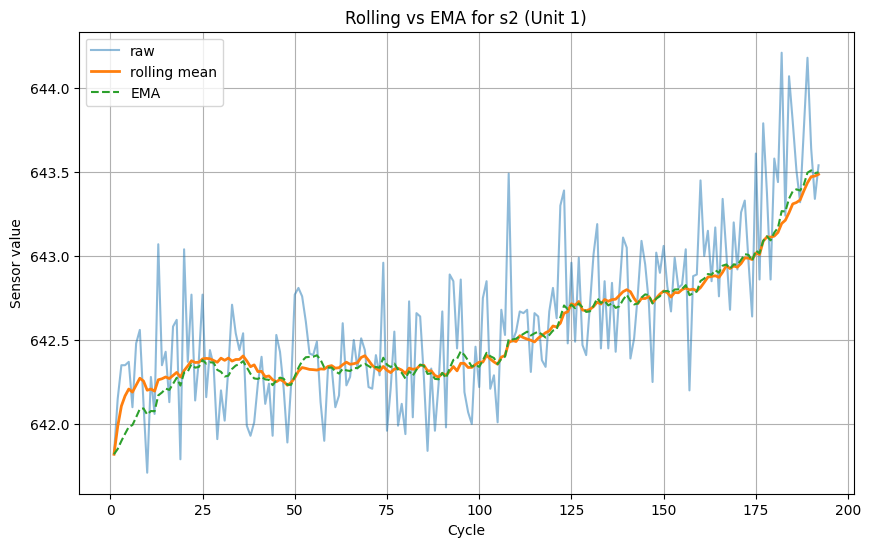

In [13]:
unit_id = 1
sensor = "s2"

df_unit = df_feat[df_feat["unit"] == unit_id]

plt.figure(figsize=(10, 6))
plt.plot(df_unit["cycle"], df_unit[sensor], label="raw", alpha=0.5)
plt.plot(df_unit["cycle"], df_unit[f"{sensor}_rollmean"], label="rolling mean", linewidth=2)
plt.plot(df_unit["cycle"], df_unit[f"{sensor}_ema"], label="EMA", linestyle="--")
plt.xlabel("Cycle")
plt.ylabel("Sensor value")
plt.title(f"Rolling vs EMA for {sensor} (Unit {unit_id})")
plt.legend()
plt.grid(True)
plt.savefig(REPORTS / f"{sensor}_rolling_vs_ema_unit{unit_id}.png", dpi=150)
plt.show()


In [14]:
print("Feature Engineering Checks")
print("- Rolling means are smoother:", df_feat["s2_rollmean"].std() < df["s2"].std())
print("- Rolling std highlights high-variance regions:", df_feat["s2_rollstd"].max() > df_feat["s2_rollstd"].median())
print("- New features created:", [c for c in df_feat.columns if "roll" in c or "ema" in c or "slope" in c])


Feature Engineering Checks
- Rolling means are smoother: True
- Rolling std highlights high-variance regions: True
- New features created: ['s2_rollmean', 's2_rollstd', 's3_rollmean', 's3_rollstd', 's4_rollmean', 's4_rollstd', 's2_ema', 's3_ema', 's4_ema', 's2_slope', 's3_slope', 's4_slope']
